In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
events_df = pd.read_csv('data/events.csv')
category_df = pd.read_csv('data/category_tree.csv')
item1_df = pd.read_csv('data/item_properties_part1.csv')
item2_df = pd.read_csv('data/item_properties_part2.csv')

In [3]:
item1_df.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [4]:
category_df.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [5]:
events_df.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [6]:
yes_bought = events_df[events_df['event'] == 'transaction']['visitorid'].unique()
yes_bought.shape

(11719,)

In [7]:
not_bought = events_df[~events_df['visitorid'].isin(yes_bought)]['visitorid'].unique()
not_bought.shape

(1395861,)

In [8]:
# items purchased together
purchased_items = []
for i in yes_bought:
    purchased_items.append(list(events_df.loc[(events_df.visitorid == i) & (events_df.transactionid.notnull())]['itemid'].values))

In [9]:
def purchased_together(itemid, purchased_items):
    recommend_list = []
    for x in purchased_items:
        if itemid in x:
            recommend_list += x
    return list(set(recommend_list) - set([itemid]))

purchased_together(302422, purchased_items)

[105792, 200793, 12836, 80582, 380775, 15335, 400969, 25353, 237753, 317178]

## Cluster visualization

In [10]:
all_visitors = events_df['visitorid'].unique()
all_visitors.size

1407580

In [11]:
def analysis_df(visitors):
    arr = []
    for ind in visitors:
        temp_df = events_df[events_df['visitorid'] == ind]
        temp = []
        temp.append(ind)
        # items viewed
        temp.append(temp_df[temp_df['event'] == 'view'].itemid.unique().size)
        # total viewed
        temp.append(temp_df[temp_df['event'] == 'view'].event.count())
        # total purchases
        tot_purchases = temp_df[temp_df['event'] == 'transaction'].event.count()
        temp.append(tot_purchases)

        if tot_purchases == 0:
            temp.append(0)
        else:
            temp.append(1)

        arr.append(temp)
    return pd.DataFrame(arr, columns=['visitorid', 'items_viewed', 'view_count', 'purchase_count', 'purchased'])

bought_df = analysis_df(yes_bought)
bought_df.head()


,visitorid,items_viewed,view_count,purchase_count,purchased
0,599528,2,15,1,1
1,121688,13,15,11,1
2,552148,1,1,1,1
3,102019,2,6,2,1
4,189384,7,25,2,1


In [12]:
not_bought_df = analysis_df(not_bought[:28000])
not_bought_df.head()

,visitorid,items_viewed,view_count,purchase_count,purchased
0,257597,2,2,0,0
1,992329,24,30,0,0
2,111016,1,2,0,0
3,483717,2,3,0,0
4,951259,1,1,0,0


In [13]:
comb_df = pd.concat([bought_df, not_bought_df], ignore_index=True)
comb_df = comb_df.sample(frac=1)

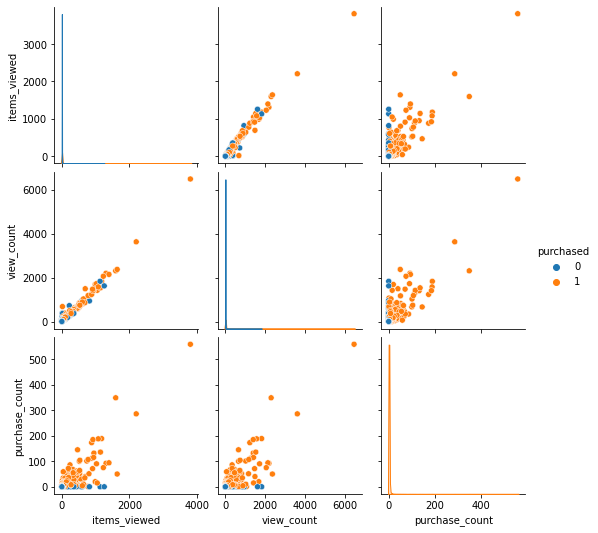

In [14]:
sns.pairplot(comb_df, x_vars=['items_viewed', 'view_count', 'purchase_count'], y_vars=['items_viewed', 'view_count', 'purchase_count'], hue='purchased')

## Predict

In [15]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance

In [16]:
comb_df['purchased'].value_counts()

0    28000
1    11719
Name: purchased, dtype: int64

In [17]:
X = comb_df.drop(['purchased', 'visitorid', 'purchase_count'], axis='columns')
y = comb_df['purchased']

In [18]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)
xtrain.shape, xtest.shape

((31775, 2), (7944, 2))

In [19]:
svc = SVC()
svc.fit(xtrain, ytrain)

SVC()

In [20]:
ypred = svc.predict(xtest)

In [21]:
accuracy_score(ytest, ypred)

0.7418177240684793

In [22]:
rf = RandomForestClassifier()
rf.fit(xtrain, ytrain)
res = permutation_importance(rf, xtest, ytest, n_repeats=10, n_jobs=2)

In [23]:
feature_names = X.columns
print([(i, j) for i, j in zip(res.importances_mean, feature_names)])

[(0.06922205438066463, 'items_viewed'), (0.1651183282980866, 'view_count')]


## Matrix Fact

In [24]:
from surprise import Reader, Dataset, NMF, SVD

In [25]:
events = events_df.copy()

In [26]:
events.columns

Index(['timestamp', 'visitorid', 'event', 'itemid', 'transactionid'], dtype='object')

In [27]:
mapper = {'view': 1, 'addtocart': 3, 'transaction': 10}
events_remapped = events.replace({'event': mapper})

In [28]:
events_remapped.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,1,355908,NaN
1,1433224214164,992329,1,248676,NaN
2,1433221999827,111016,1,318965,NaN
3,1433221955914,483717,1,253185,NaN
4,1433221337106,951259,1,367447,NaN


In [29]:
events_remapped = events_remapped.sample(frac=0.5)
events_remapped.shape

(1378050, 5)

In [30]:
events_filt = events_remapped.groupby('itemid').filter(lambda x: x['itemid'].count() >= 2)
events_filt = events_filt.groupby('visitorid').filter(lambda x: x['visitorid'].count() >= 5)
events_filt.shape

(319730, 5)

In [31]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(events_filt[['visitorid', 'itemid', 'event']], reader)
trainset = data.build_full_trainset()
# testset = trainset.build_anti_testset()

In [32]:
testset = trainset.build_anti_testset()

KeyboardInterrupt: 

## LightGBM Ranking

In [35]:
import lightgbm as lgb

In [36]:
events_filt.shape

(319730, 5)

In [37]:
events_filt.head()

,timestamp,visitorid,event,itemid,transactionid
352909,1434668033439,1000306,1,437006,NaN
2259042,1436666553575,371606,1,327150,NaN
81606,1433433431660,833253,1,215645,NaN
733206,1438973716633,1033926,3,245158,NaN
858468,1439606755167,722706,1,239555,NaN


In [39]:
ranking_df = events_filt.drop(columns=['timestamp', 'transactionid'])
ranking_df.head()

,visitorid,event,itemid
352909,1000306,1,437006
2259042,371606,1,327150
81606,833253,1,215645
733206,1033926,3,245158
858468,722706,1,239555


In [40]:
train = ranking_df[:4*ranking_df.shape[0]//5]
test = ranking_df[4*ranking_df.shape[0]//5:]
train.shape, test.shape

((255784, 3), (63946, 3))

In [59]:
x_train = train.drop(['visitorid', 'event'], axis=1)
y_train = train['event'].astype(int)
qids_train = train.groupby('visitorid')['visitorid'].count().to_numpy()

In [68]:
x_test = test.drop(['visitorid', 'event'], axis=1)
y_test = test['event'].astype(int)
qids_test = test.groupby('visitorid')['visitorid'].count().to_numpy()

In [69]:
x_train.shape, x_test.shape, qids_train.shape

((255784, 1), (63946, 1), (28530,))

In [70]:
model = lgb.LGBMRanker(n_estimators=250, max_depth=15, objective='lambdarank', metric='ndcg')
model.fit(x_train, y_train, group=qids_train, eval_set=[(x_test, y_test)], eval_group=[qids_test], eval_at=10, verbose=10)

C:\Users\tg584\AppData\Local\Programs\Python\Python37\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's ndcg@10: 0.962402
[20]	valid_0's ndcg@10: 0.961665
[30]	valid_0's ndcg@10: 0.962351
[40]	valid_0's ndcg@10: 0.962346
[50]	valid_0's ndcg@10: 0.962149
[60]	valid_0's ndcg@10: 0.962691
[70]	valid_0's ndcg@10: 0.962581
[80]	valid_0's ndcg@10: 0.962888
[90]	valid_0's ndcg@10: 0.962367
[100]	valid_0's ndcg@10: 0.962543
[110]	valid_0's ndcg@10: 0.961884
[120]	valid_0's ndcg@10: 0.962353
[130]	valid_0's ndcg@10: 0.961991
[140]	valid_0's ndcg@10: 0.962426
[150]	valid_0's ndcg@10: 0.962181
[160]	valid_0's ndcg@10: 0.961919
[170]	valid_0's ndcg@10: 0.961905
[180]	valid_0's ndcg@10: 0.962094
[190]	valid_0's ndcg@10: 0.962604
[200]	valid_0's ndcg@10: 0.962511
[210]	valid_0's ndcg@10: 0.962535
[220]	valid_0's ndcg@10: 0.96242
[230]	valid_0's ndcg@10: 0.962407
[240]	valid_0's ndcg@10: 0.963109
[250]	valid_0's ndcg@10: 0.962613


LGBMRanker(max_depth=15, metric='ndcg', n_estimators=250,
           objective='lambdarank')

In [71]:
y_pred = model.predict(x_test)
x_test['pred_ranking'] = y_pred


In [72]:
x_test_rank = x_test.sort_values('pred_ranking', ascending=False)
x_test_rank.head()

,itemid,pred_ranking
1594604,461686,3.367475
1106727,461686,3.367475
2434020,461686,3.367475
1040574,461553,3.367475
369140,461686,3.367475


#### Alt

In [52]:
x_train = train.drop(['itemid', 'event'], axis=1)
y_train = train['event'].astype(int)
qids_train = train.groupby('itemid')['itemid'].count().to_numpy()

x_test = test.drop(['itemid', 'event'], axis=1)
y_test = test['event'].astype(int)
qids_test = test.groupby('itemid')['itemid'].count().to_numpy()

In [53]:
model1 = lgb.LGBMRanker(objective='lambdarank', metric='ndcg')
model1.fit(x_train, y_train, group=qids_train, eval_set=[(x_test, y_test)], eval_group=[qids_test], eval_at=10, verbose=10)

C:\Users\tg584\AppData\Local\Programs\Python\Python37\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's ndcg@10: 0.972995
[20]	valid_0's ndcg@10: 0.972935
[30]	valid_0's ndcg@10: 0.972979
[40]	valid_0's ndcg@10: 0.973146
[50]	valid_0's ndcg@10: 0.97311
[60]	valid_0's ndcg@10: 0.973129
[70]	valid_0's ndcg@10: 0.973075
[80]	valid_0's ndcg@10: 0.972992
[90]	valid_0's ndcg@10: 0.973025
[100]	valid_0's ndcg@10: 0.973158


LGBMRanker(metric='ndcg', objective='lambdarank')